In [1]:
# !pip install pytrends

from pandas_datareader import data as pdr
from datetime import date
# import yfinance as yf
# yf.pdr_override()
import pandas as pd
# import matplotlib.pyplot as plt
# import plotly.offline as pyo

from pytrends.request import TrendReq
# import plotly.graph_objs as go

# pyo.init_notebook_mode()

# import yahoofinance as yf

## Import py trends

In [2]:
pytrend = TrendReq()

In [3]:
df = pytrend.trending_searches(pn='ukraine')#, start_data='06-04-2021', end_data='07-04-2021')
df.head(30)

,0
0,8 апреля праздник
1,День ангела Алла
2,Ольга Пашкова
3,Какой сегодня праздник
4,Челси
5,Ювентус – Наполі
6,Праздник сегодня
7,8 квітня свято
8,Березовий сік
9,Челси Порту


In [5]:
kw_list = [
          'bitcoin', 
          'bitcoin price',
          'bitcoin usd',
          'bitcoin kurs',
            'Bitcoin.com',
            'Bitcoin Gold',
           'BTC-USD',     
            'Bitcoin Cash',
       'binance',
    
    
            'cryptocurrency',
            'cryptocurrency bitcoin',
           'news cryptocurrency',
           'crypto',
           'buy bitcoin',
           'bitcoin stock',
           'best cryptocurrency',
           'cryptocurrency market',
           'buy cryptocurrency',
           'what is cryptocurrency',
           'cryptocurrency exchange',
          ]

def get_data_from_query(kw_list, timeframe='today 5-y', save=True):
    for word in kw_list:
        word_l = [word]
        get_result = pytrend.build_payload(word_l, cat=0, timeframe='today 5-y', geo='', gprop='')
        result = pytrend.interest_over_time()
        
        if save:
            result.to_csv(f'{word}_5YearAgo.csv')

            cryptocurrency exchange isPartial
date                                         
2016-04-10                        1     False
2016-04-17                        0     False
2016-04-24                        0     False
2016-05-01                        0     False
2016-05-08                        1     False
...                             ...       ...
2021-03-07                       10     False
2021-03-14                        9     False
2021-03-21                       10     False
2021-03-28                       10     False
2021-04-04                       12      True

[261 rows x 2 columns]


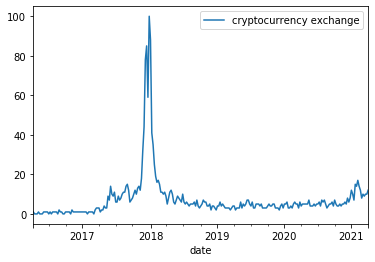

In [4]:
kw_list = [
          'bitcoin', 
          'bitcoin price',
          'bitcoin usd',
          'bitcoin kurs',
            'Bitcoin.com',
            'Bitcoin Gold',
           'BTC-USD',     
            'Bitcoin Cash',
       'binance',
    
    
            'cryptocurrency',
            'cryptocurrency bitcoin',
           'news cryptocurrency',
           'crypto',
           'buy bitcoin',
           'bitcoin stock',
           'best cryptocurrency',
           'cryptocurrency market',
           'buy cryptocurrency',
           'what is cryptocurrency',
           'cryptocurrency exchange',
          ]
for word in kw_list:
    word_l = [word]
    get_result = pytrend.build_payload(word_l, cat=0, timeframe='today 5-y', geo='', gprop='')
    result = pytrend.interest_over_time()
    result.to_csv(f'{word}_5YearAgo.csv')

print(result)
result.plot()